# explore data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
%matplotlib inline

In [2]:
%%time
dtypes={
    'price': 'float32',
    'item_seq_number': 'uint16',
    'image_top_1':'float32',
    'deal_probabilty':'float32'
}
## train 
df_train = pd.read_csv('../input/train.csv.zip',compression='zip',parse_dates=['activation_date'],dtype=dtypes)
## periods train -- Supplemental data showing the dates when the ads from train_active.csv were activated and when they where displayed.
df_per_train = pd.read_csv('../input/periods_train.csv.zip',compression='zip',parse_dates=['activation_date','date_from','date_to'])
## train  active
df_test = pd.read_csv('../input/test.csv.zip',compression='zip',dtype=dtypes,parse_dates=['activation_date'])

CPU times: user 1min 21s, sys: 2.38 s, total: 1min 23s
Wall time: 1min 23s


In [3]:
%%time
dtypes1 = {
    'item_seq_number':'float16',
    'price':'float32'
}
# from_rows= 10000
# to_rows = 20000
# nrows = to_rows -from_rows 
# nrows = 10000
df_act_trn = pd.read_csv('../input/train_active.csv.zip',compression='zip',dtype=dtypes1,parse_dates=['activation_date'],
                         usecols=['item_id','user_id','city','activation_date']
                        )

CPU times: user 2min 3s, sys: 2.66 s, total: 2min 5s
Wall time: 2min 7s


# preprocess trick

memory handle and increase the overall workflow speed from loading data to creating numerical features.

most of them copy from [here](https://www.kaggle.com/frankherfert/tips-tricks-for-working-with-large-datasets/code)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float32
item_seq_number         1503424 non-null uint16
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float32
deal_probability        1503424 non-null float64
dtypes: dateti

In [6]:
df_train.memory_usage(deep=True)*1e-6

Index                     0.000080
item_id                 103.736256
user_id                 103.736256
region                  175.523224
city                    149.200882
parent_category_name    159.927206
category_name           180.110126
param_1                 154.299798
param_2                 105.593229
param_3                  85.584612
title                   183.250065
description             658.519753
price                     6.013696
item_seq_number           3.006848
activation_date          12.027392
user_type                95.977729
image                   171.893972
image_top_1               6.013696
deal_probability         12.027392
dtype: float64

use category instead of Object

In [4]:
def convert_columns_to_catg(df, column_list):
    for col in column_list:
        print("converting", col.ljust(30), "size: ", round(df[col].memory_usage(deep=True)*1e-6,2), end="\t")
        df[col] = df[col].astype("category")
        print("->\t", round(df[col].memory_usage(deep=True)*1e-6,2))

In [5]:
convert_columns_to_catg(df_train, ['city','region',"param_1","param_2","param_3","parent_category_name","category_name", "user_type"])

converting city                           size:  149.2	->	 3.3
converting region                         size:  175.52	->	 1.51
converting param_1                        size:  154.3	->	 3.06
converting param_2                        size:  105.84	->	 3.04
converting param_3                        size:  85.66	->	 3.13
converting parent_category_name           size:  159.93	->	 1.5
converting category_name                  size:  180.11	->	 1.51
converting user_type                      size:  95.98	->	 1.5


In [6]:
df_train.memory_usage(deep=True)/(2**20) # MB

Index                     0.000076
item_id                  98.930603
user_id                  98.930603
region                    1.439054
city                      3.143326
parent_category_name      1.435184
category_name             1.441661
param_1                   2.914475
param_2                   2.901285
param_3                   2.984812
title                   174.760999
description             628.012864
price                     5.735107
item_seq_number           2.867554
activation_date          11.470215
user_type                 1.434033
image                   163.930866
image_top_1               5.735107
deal_probability         11.470215
dtype: float64

In [7]:
cat_cols=['city','region',"param_1","param_2","param_3","parent_category_name","category_name", "user_type"]
convert_columns_to_catg(df_test,cat_cols)

converting city                           size:  50.43	->	 1.3
converting region                         size:  59.26	->	 0.51
converting param_1                        size:  51.94	->	 1.07
converting param_2                        size:  34.82	->	 1.05
converting param_3                        size:  27.86	->	 1.12
converting parent_category_name           size:  54.09	->	 0.51
converting category_name                  size:  60.6	->	 0.52
converting user_type                      size:  32.45	->	 0.51


pickle it 

In [8]:
df_train.to_pickle('../input/train.pkl')
df_test.to_pickle('../input/test.pkl')
# size is shown in bytes again and needs to be converted to megabytes
print("train.csv.zip:", os.stat('../input/train.csv.zip').st_size * 1e-6)
print("train.pkl:", os.stat('../input/train.pkl').st_size * 1e-6)

print("test.csv.zip:", os.stat('../input/test.csv.zip').st_size * 1e-6)
print("test.pkl:", os.stat('../input/test.pkl').st_size * 1e-6)

train.csv.zip: 322.55268
train.pkl: 719.444979
test.csv.zip: 112.37416999999999
test.pkl: 250.91228099999998


load

In [2]:
%%time 
df_train = pd.read_pickle('../input/train.pkl')

CPU times: user 3.08 s, sys: 784 ms, total: 3.86 s
Wall time: 4.24 s


___

# Label encoding

In [44]:
df_train.region.value_counts().tail()

Белгородская область    28868
Ханты-Мансийский АО     28709
Удмуртия                28537
Владимирская область    26741
Тульская область        25733
Name: region, dtype: int64

In [45]:
df_train.user_id.value_counts().tail()

7135b1db86a6    1
ee807c843259    1
968fae4fbda3    1
bf26da052da7    1
4c8b0bb81e6f    1
Name: user_id, dtype: int64

we need create count threshold for user_id 

In [52]:
from sklearn.preprocessing import LabelEncoder

In [64]:
def create_label_encoding_with_min_count(df, column, min_count=50):
    column_counts = df.groupby([column])[column].transform("count").astype(int)
    column_values = np.where(column_counts >= min_count, df[column], "")
    df[column+"_label"] = LabelEncoder().fit_transform(column_values)
    
    return df[column+"_label"]

In [70]:
print("number of unique users      :", len(df_train["user_id"].unique()))
print("number of unique user labels:", len(df_train["user_id_label"].unique()))

number of unique users      : 771769
number of unique user labels: 562


multi_column encoding

In [72]:
df_train.loc[df_train["city"]=="Светлый", "region"].value_counts().head()

Калининградская область    179
Саратовская область         36
Оренбургская область         5
Ярославская область          0
Новосибирская область        0
Name: region, dtype: int64

In [76]:
df_train['region_city'] = df_train.loc[:,['region','city']].apply(lambda s: ' '.join(s),axis=1)

In [77]:
print("unique:", len(df_train["region_city"].unique()))
print("size:  ", df_train["region_city"].memory_usage(deep=True)*1e-6) ## not only time cost, but memory used a lot,

unique: 1804
size:   284.043633


In [81]:
df_train['region_city2'] = df_train.groupby(['region','city'])['region'].transform(lambda x:np.random.random()) ## faster and encode it correctly!!
df_train.region_city2.value_counts().head()

0.822676    63638
0.025276    63602
0.670610    56929
0.781169    52323
0.530917    52010
Name: region_city2, dtype: int64

In [83]:
print("unique:", len(df_train["region_city2"].unique()))
print("size:  ", df_train["region_city2"].memory_usage(deep=True)*1e-6)

unique: 1804
size:   12.027472


In [84]:
df_train['region_city2_label']=create_label_encoding_with_min_count(df_train,'region_city2',min_count=50)

In [86]:
df_train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability',
       'user_id_label', 'region_city', 'region_city2', 'region_city2_label'],
      dtype='object')

In [85]:
gc.collect()

2137

#### description, title words numbers

In [91]:
df_train['title'] = df_train.title.fillna(" ")
df_train['title_len'] = df_train.title.apply(lambda x:len(x.split())).astype('uint8')
df_train['title_char'] = df_train.title.apply(len).astype('uint8')

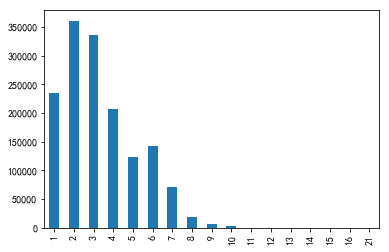

In [92]:
df_train.title_len.value_counts(sort=False).plot(kind='bar')

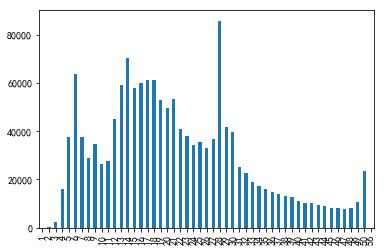

In [93]:
df_train.title_char.value_counts(sort=False).plot(kind='bar')

description 

In [94]:
df_train['description'] = df_train.description.fillna(" ")
df_train['description_len'] = df_train.description.apply(lambda x:len(x.split())).astype('uint16')
df_train['description_char'] = df_train.description.apply(len).astype('uint16')

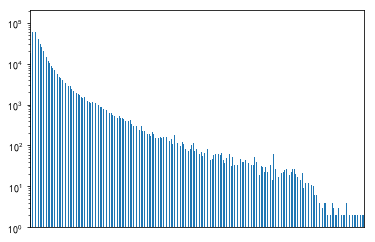

In [95]:
ax = df_train.description_len.value_counts(sort=False).plot(kind='bar',log=True)
# ax.axis('off')
ax.get_xaxis().set_visible(False)

In [96]:
df_train.description_char.value_counts().head()#.plot(kind='bar',log=True)


1     116616
19     10376
20      9823
44      9497
37      9484
Name: description_char, dtype: int64

In [99]:
df_train.corr()

,price,item_seq_number,image_top_1,deal_probability,user_id_label,region_city2,region_city2_label,title_len,title_char,description_len,description_char
price,1.000000,0.005330,0.034404,-0.001097,0.002833,0.000187,0.000157,0.004445,0.002057,0.003331,0.003407
item_seq_number,0.005330,1.000000,0.100856,-0.042210,0.480811,0.058882,0.059850,0.154716,0.110947,0.146994,0.153766
image_top_1,0.034404,0.100856,1.000000,0.189979,0.114632,0.025886,0.021184,0.246651,0.181581,0.186783,0.189068
deal_probability,-0.001097,-0.042210,0.189979,1.000000,-0.070740,0.001743,0.001783,0.016143,0.014537,-0.000968,0.002225
user_id_label,0.002833,0.480811,0.114632,-0.070740,1.000000,0.039893,0.042487,0.185151,0.169411,0.254417,0.258256
region_city2,0.000187,0.058882,0.025886,0.001743,0.039893,1.000000,0.977572,0.027970,0.018207,0.017674,0.018524
region_city2_label,0.000157,0.059850,0.021184,0.001783,0.042487,0.977572,1.000000,0.022780,0.018290,0.018905,0.019547
title_len,0.004445,0.154716,0.246651,0.016143,0.185151,0.027970,0.022780,1.000000,0.855498,0.311825,0.312124
title_char,0.002057,0.110947,0.181581,0.014537,0.169411,0.018207,0.018290,0.855498,1.000000,0.312667,0.315814
description_len,0.003331,0.146994,0.186783,-0.000968,0.254417,0.017674,0.018905,0.311825,0.312667,1.000000,0.989991


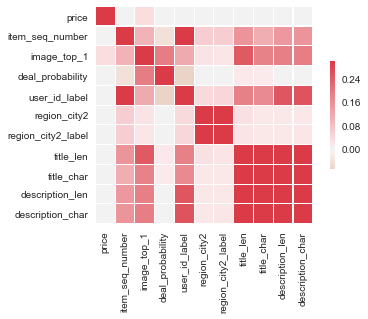

In [100]:
corr = df_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

cmap = sns.diverging_palette(30,10,as_cmap=True)
sns.heatmap(corr,cmap=cmap,center=0,square=True,vmax=.3,linewidths=.1, cbar_kws={"shrink": .5});

____

encode `user_id`, `item_seq_numbers` with `uidx`, `iidx`

In [103]:
import scipy.sparse as sp

In [102]:
def get_df_matrix_mappings(df, row_name, col_name):
    # Create mappings
    rid_to_idx = {}
    idx_to_rid = {}
    for (idx, rid) in enumerate(df[row_name].unique().tolist()):
        rid_to_idx[rid] = idx
        idx_to_rid[idx] = rid


    cid_to_idx = {}
    idx_to_cid = {}
    for (idx, cid) in enumerate(df[col_name].unique().tolist()):
        cid_to_idx[cid] = idx
        idx_to_cid[idx] = cid


    return rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid

In [104]:
rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = get_df_matrix_mappings(df_train,'user_id','item_seq_number')

In [105]:
df_trn_uidx = pd.DataFrame()
df_trn_uidx['uidx']= df_train.user_id.map(rid_to_idx)
df_trn_uidx['iidx']= df_train.item_seq_number.map(cid_to_idx)
df_trn_uidx['uid'] = df_train.user_id
df_trn_uidx['iid'] = df_train.item_seq_number

In [106]:
df_trn_uidx.head()

,uidx,iidx,uid,iid
0,0,0,e00f8ff2eaf9,2
1,1,1,39aeb48f0017,19
2,2,2,91e2f88dd6e3,9
3,3,3,bf5cccea572d,286
4,4,4,ef50846afc0b,3


In [58]:
# df_train[['user_id','item_id']].drop_duplicates().shape # no duplicated u-i combiniation

In [107]:
I = df_trn_uidx.uidx.as_matrix()
J = df_trn_uidx.iidx.as_matrix()
V = np.ones(df_trn_uidx.shape[0])

ui_trn_sp = sp.coo_matrix((V,(I,J)),dtype='uint8')

In [108]:
ui_trn_sp.shape ## 

(771769, 26079)

In [109]:
ui_trn_csr =ui_trn_sp.tocsr()

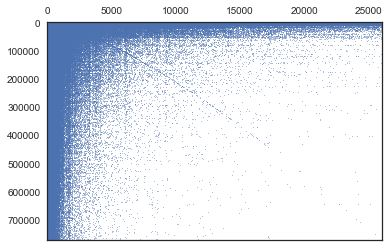

In [112]:
plt.spy(ui_trn_csr,markersize=0.5,aspect='auto')

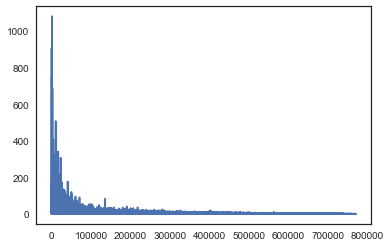

In [113]:
plt.plot(np.array(ui_trn_csr.sum(axis=1)).flatten()) ## smaller uidx --> larger # of item ad displayed

smaller uidx --> more # of items ad displayed !!

In [129]:
df_train['iidx'] = df_train.item_seq_number.map(cid_to_idx).astype('uint16')
df_train['uidx'] = df_train.user_id.map(rid_to_idx).astype('uint32')

In [135]:
df_train.groupby(['uidx','iidx']).size().value_counts() ##  uidx-iidx is unique

1    1503424
dtype: int64

In [140]:
df_train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability',
       'user_id_label', 'region_city', 'region_city2', 'region_city2_label',
       'title_len', 'title_char', 'description_len', 'description_char',
       'iidx', 'uidx'],
      dtype='object')

In [141]:
df_trn_uidx = df_trn_uidx.merge(df_train[['uidx','iidx','deal_probability']] , how ='left',on=['uidx','iidx'])

In [144]:
I = df_trn_uidx.uidx.as_matrix()
J = df_trn_uidx.iidx.as_matrix()
Vp = df_trn_uidx.deal_probability
ui_trn_deal = sp.coo_matrix((Vp,(I,J)),dtype='float32')

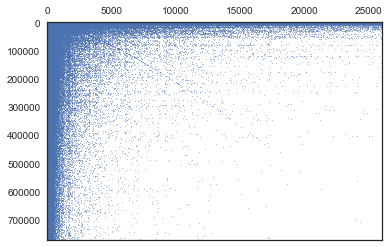

In [146]:
# plt.spy(ui_trn_deal,markersize=0.5,aspect='auto')


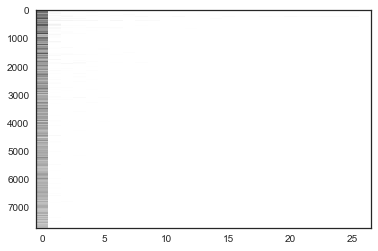

In [229]:
## heatmat 
## from stackoverflow https://stackoverflow.com/questions/42210594/plot-heatmap-of-sparse-matrix?rq=1
data = ui_trn_deal.tocsc()       # sparse operations are more efficient on csc
N, M = data.shape
s, t = 100, 1000           # decimation factors for y and x directions
T = sp.csc_matrix((np.ones((M,)), np.arange(M), np.r_[np.arange(0, M, t), M]), (M, (M-1) // t + 1))
S = sp.csr_matrix((np.ones((N,)), np.arange(N), np.r_[np.arange(0, N, s), N]), ((N-1) // s + 1, N))
result = S @ data @ T     # downsample by binning into s x t rectangles
result = result.todense() # ready for plotting
plt.imshow(result,cmap='gray_r',aspect='auto') ## 

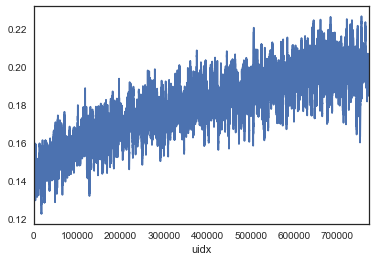

In [267]:
df_train.groupby('uidx')['deal_probability'].mean().rolling(1000).mean().plot() 

uidx in some way sort ad_cnt_by_user, this cnt numbers affect deal prob

In [276]:
tmp = df_train.groupby('uidx').size().to_frame().reset_index().rename(columns={0:'ads_cnt_by_uid'})

In [277]:
tmp.

,uidx,ads_cnt_by_uid
0,0,1
1,1,1
2,2,2
3,3,1
4,4,1


In [278]:
print('doing add cnt by user_id...')
tmp = df_train.groupby('uidx').size().to_frame().reset_index().rename(columns={0:'ads_cnt_by_uid'})
tmp['ads_cnt_by_uid'] = tmp.ads_cnt_by_uid.astype('uint32')
df_train = df_train.merge(tmp,how='left' ,on='uidx')

print('doing add cnt by iidx(item_seq_number)...')
tmp = df_train.groupby('iidx').size().to_frame().reset_index().rename(columns={0:'ads_cnt_by_iid'})
tmp['ads_cnt_by_iid'] = tmp.ads_cnt_by_iid.astype('uint32')
df_train =  df_train.merge(tmp,how='left' ,on='iidx')
print('done')
del tmp; gc.collect()

doing add cnt by user_id...
doing add cnt by iidx(item_seq_number)...
done


127

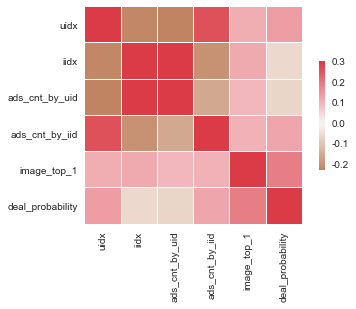

In [281]:
usecols = ['uidx','iidx','ads_cnt_by_uid','ads_cnt_by_iid','image_top_1','deal_probability']

corr = df_train[usecols].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

cmap = sns.diverging_palette(30,10,as_cmap=True)
sns.heatmap(corr,cmap=cmap,center=0,square=True,vmax=.3,linewidths=.1, cbar_kws={"shrink": .5});

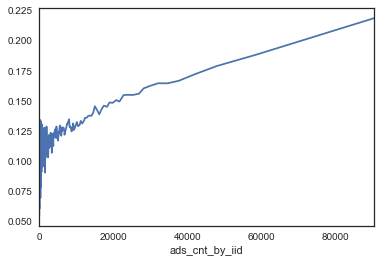

In [314]:
df_train.groupby('ads_cnt_by_iid')['deal_probability'].mean().plot()

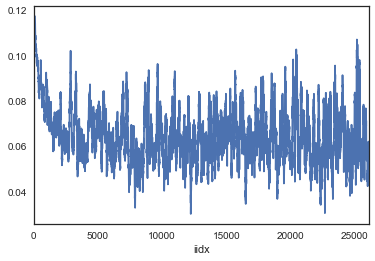

In [315]:
df_train.groupby('iidx')['deal_probability'].mean().rolling(100).mean().plot()

____

- number of unique uid

In [16]:
df_train.user_id.nunique() # 771,769 out of 1,503,424 

771769

In [18]:
df_test.user_id.nunique() # 306,069 

306069

In [86]:
uid_in_trn_test = np.intersect1d(df_test.user_id,df_train.user_id) # overlap # of user 67,929
pd.Series(uid_in_trn_test).nunique()

67929

In [32]:
test_uid = df_test.user_id.unique()
train_uid = df_train.user_id.unique()

- number of unique itemid

In [40]:
train_itemid = df_train.item_id.unique()
test_itemid = df_test.item_id.unique()

In [41]:
train_itemid.size  # equal to # of df_train

1503424

In [42]:
test_itemid.size

508438

In [43]:
itmid_in_trn_test = np.intersect1d(train_itemid,test_itemid)

In [61]:
itmid_in_trn_test.size

0

**itemid** is pkey in train/test sets

In [203]:
num_items_by_user = np.array(ui_trn_csr.sum(axis=1).flatten())[0]
pd.Series(num_items_by_user).value_counts().head() ## 


1    531750
2    116739
3     47878
4     24779
5     14792
dtype: int64

In [204]:
pd.Series(sum_iid_by_user).value_counts(normalize=True).head()

1    0.689002
2    0.151262
3    0.062037
4    0.032107
5    0.019166
dtype: float64

most of user only have 1 itemid (68.9%) in training sets

- date range ? 

In [5]:
print('max of df_train.activation_date',df_train.activation_date.max())
print('min of df_train.activation_date',df_train.activation_date.min())

max of df_train.activation_date 2017-04-07 00:00:00
min of df_train.activation_date 2017-03-15 00:00:00


In [11]:
df_train.activation_date.value_counts()

2017-03-20    115190
2017-03-27    114863
2017-03-19    114416
2017-03-26    113513
2017-03-28    112885
2017-03-21    110535
2017-03-22    109813
2017-03-15    108615
2017-03-23    106544
2017-03-16    106168
2017-03-17     98773
2017-03-18     97554
2017-03-24     97351
2017-03-25     97104
2017-03-29        87
2017-04-01         3
2017-03-30         3
2017-04-02         3
2017-04-03         2
2017-04-07         1
2017-03-31         1
Name: activation_date, dtype: int64

In [6]:
print('max of df_per_train.activation_date',df_per_train.activation_date.max())
print('min of df_per_train.activation_date',df_per_train.activation_date.min())

print('max of df_per_train.date_from',df_per_train.date_from.max())
print('min of df_per_train.date_from',df_per_train.date_from.min())

print('max of df_per_train.date_to',df_per_train.date_to.max())
print('min of df_per_train.date_to',df_per_train.date_to.min())

max of df_per_train.activation_date 2017-03-28 00:00:00
min of df_per_train.activation_date 2017-01-01 00:00:00
max of df_per_train.date_from 2017-03-28 00:00:00
min of df_per_train.date_from 2017-03-15 00:00:00
max of df_per_train.date_to 2017-03-28 00:00:00
min of df_per_train.date_to 2017-03-15 00:00:00


In [13]:
df_act_trn.activation_date.value_counts() ## 3/15 - 3/27 

2017-03-15    12246008
2017-03-16      206064
2017-03-17      171405
2017-03-20      162183
2017-03-19      159018
2017-03-18      151699
2017-03-21      148612
2017-03-22      146814
2017-03-23      131640
2017-03-27      128207
2017-03-26      122839
2017-03-24      118500
2017-03-25      112509
Name: activation_date, dtype: int64

In [15]:
df_per_train.shape

(16687412, 4)

In [16]:
df_act_trn.shape

(14129821, 4)

In [22]:
# df_per_train.activation_date.value_counts()

In [18]:
df_per_train.date_from.value_counts()

2017-03-15    12070638
2017-03-20      414531
2017-03-22      396834
2017-03-27      391854
2017-03-21      378197
2017-03-23      372507
2017-03-16      367473
2017-03-19      357980
2017-03-17      353858
2017-03-24      351372
2017-03-26      345656
2017-03-18      323756
2017-03-25      313923
2017-03-28      248833
Name: date_from, dtype: int64

`train_active`: Supplemental data from ads that were displayed during the same period as train.csv. Same schema as the train data minus deal_probability, image, and image_top_1.

`periods_train`:Supplemental data showing the dates when the ads from train_active.csv were activated and when they where displayed.
    - item_id         :  map to 
    - activation_date :　date ad was placed
    - date_from       :  first date ad was displayed
    - date_to         :  last date ad was displayed

train_active sampling .... very large (2.3G)

In [21]:
print('# of item_id : train active ',df_act_trn.item_id.nunique()) ## 10,000 rows, nunique:9,919
print('# of item_id : periods train', df_per_train.item_id.nunique()) ## 16,687,412 rows, nunique:: 13,812,546

# of item_id : train active  9919
# of item_id : periods train 13812546


In [23]:
print('# of item_id: train ',df_train.item_id.nunique()) ## 1,503,424 rows, nunique: 1,503,424 ---> pkey

# of item_id: train  1503424


In [27]:
df_per_train.head()

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


In [6]:
df_act_trn.head()

,item_id,user_id,city,activation_date
0,70d6342079ef,11d4c04d8c51,Нижний Новгород,2017-03-15
1,97cf505710e1,d7068c60b2c6,Воронеж,2017-03-27
2,6a93a31a945d,755c88999bc7,Нижний Новгород,2017-03-15
3,050cade37667,3d7fb2abdbbc,Стерлитамак,2017-03-15
4,2935e85aa40b,fc1be1a809d1,Казань,2017-03-15


* itemid in train not shown in summplement (active, periods )?
    - itemid do not overlap in train & supplement (active, periods)

In [31]:
# (df_train.item_id.head(5))
# df_per_train[df_per_train.item_id.isin(df_train.item_id.tail(20))]

In [30]:
df_train.merge(df_per_train,how='inner',on=['item_id'])

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,price,item_seq_number,activation_date_x,user_type,image,image_top_1,deal_probability,activation_date_y,date_from,date_to


- user in trn & active

In [41]:
df_train[df_train.user_id.isin(df_act_trn.user_id.head())]

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
1186888,8e45b14e41bf,3d7fb2abdbbc,Башкортостан,Стерлитамак,Бытовая электроника,Телефоны,Аксессуары,Запчасти,NaN,Дисплей 5c,Продается ДисплейныйМодуль на айфон 5С(Ц) /\n...,2400.0,163,2017-03-19,Company,af5ee8e87a06ad3d88f84eaac1a75a7869d8e63b8a855c...,3033.0,0.00000
1285299,0e079b32a889,755c88999bc7,Нижегородская область,Нижний Новгород,Недвижимость,Коммерческая недвижимость,Сдам,Торговое помещение,NaN,"Торговое помещение, 100 м²",Сдам торговое помещение с высокой проходимость...,200000.0,5,2017-03-22,Private,af83fbd67cb54a9639507935b714fc44594099d5967b52...,1177.0,0.31598


* supplement : active , periods train --> foreign id 
    - `item_id  `
    - `periods.date_from = active.activation_date`
     

In [25]:
# act_trn_itemid= ['97cf505710e1','70d6342079ef','6a93a31a945d','2935e85aa40b'] ## head 5 itemid in active train
act_trn_itemid = df_act_trn.item_id.head(10)
df_per_train[df_per_train.item_id.isin(act_trn_itemid)]

,item_id,activation_date,date_from,date_to
469028,050cade37667,2017-03-01,2017-03-15,2017-03-28
6537692,4b1edf5131ea,2017-03-02,2017-03-15,2017-03-28
10670109,58eaf7ee876b,2017-02-14,2017-03-15,2017-03-16
10817424,97cf505710e1,2017-03-27,2017-03-27,2017-03-28
11137492,6a93a31a945d,2017-02-14,2017-03-15,2017-03-16
11159745,70d6342079ef,2017-03-14,2017-03-15,2017-03-28
11581735,2935e85aa40b,2017-03-13,2017-03-15,2017-03-28
13386480,deb7355cbd7e,2017-02-18,2017-03-15,2017-03-19
13869542,c301c65863e0,2017-02-23,2017-03-15,2017-03-23
14471669,4df800b9dbb5,2017-02-20,2017-03-15,2017-03-19


In [39]:
df_act_trn.head(20).merge(df_per_train,left_on=['item_id','activation_date'],right_on=['item_id','date_from'],how='inner')

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date_x,user_type,activation_date_y,date_from,date_to
0,70d6342079ef,11d4c04d8c51,Нижегородская область,Нижний Новгород,Хобби и отдых,Книги и журналы,Книги,NaN,NaN,Детская знциклопедия,"детская энциклопедия,10 томов, в книге 630 стр...",200.0,20.0,2017-03-15,Private,2017-03-14,2017-03-15,2017-03-28
1,97cf505710e1,d7068c60b2c6,Воронежская область,Воронеж,Недвижимость,Гаражи и машиноместа,Продам,Гараж,Кирпичный,"Гараж, > 30 м²","Продается ГАРАЖ в ПГСК Алмаз/\nУдобный въезд, ...",590000.0,23.0,2017-03-27,Private,2017-03-27,2017-03-27,2017-03-28
2,6a93a31a945d,755c88999bc7,Нижегородская область,Нижний Новгород,Недвижимость,Коммерческая недвижимость,Сдам,Торговое помещение,NaN,"Торговое помещение, 50-5000 м²",Сдаем в аренду лучшие торговые помещения Н.Нов...,100000.0,4.0,2017-03-15,Private,2017-02-14,2017-03-15,2017-03-16
3,050cade37667,3d7fb2abdbbc,Башкортостан,Стерлитамак,Бытовая электроника,Телефоны,Аксессуары,Аккумуляторы,NaN,Аккумулятор на 5s / 5c,"продам батарею на iphone 5s , 5с",750.0,157.0,2017-03-15,Company,2017-03-01,2017-03-15,2017-03-28
4,2935e85aa40b,fc1be1a809d1,Татарстан,Казань,Для дома и дачи,Ремонт и строительство,Камины и обогреватели,NaN,NaN,"Заглушки, дверцы, плита","Всё для печи: плита, заглушка, дверцы- всё нов...",3900.0,27.0,2017-03-15,Private,2017-03-13,2017-03-15,2017-03-28
5,deb7355cbd7e,7fe1e284ccff,Саратовская область,Вольск,Для дома и дачи,Ремонт и строительство,Инструменты,NaN,NaN,Советская дрель,Продам советскую дрель в хорошем состоянии . П...,1000.0,44.0,2017-03-15,Private,2017-02-18,2017-03-15,2017-03-19
6,c301c65863e0,d9b66fb7c34a,Удмуртия,Ижевск,Личные вещи,Товары для детей и игрушки,Детская мебель,NaN,NaN,Двух-ярусная кровать,"Продам двух-ярусную кровать, длина180 см,полно...",4500.0,46.0,2017-03-15,Private,2017-02-23,2017-03-15,2017-03-23
7,4df800b9dbb5,316092fe1dca,Ростовская область,Ростов-на-Дону,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Нижнее бельё,42–44 (S),Пояс под чулки Италия,"два пояса, новых, цена дешевле магазинной",600.0,69.0,2017-03-15,Shop,2017-02-20,2017-03-15,2017-03-19
8,58eaf7ee876b,e1b372a5db8f,Краснодарский край,Краснодар,Хобби и отдых,Книги и журналы,Книги,NaN,NaN,Луис Ламур,Неполное собрание книг от писателя Луис Ламур....,1000.0,13.0,2017-03-15,Private,2017-02-14,2017-03-15,2017-03-16
9,4b1edf5131ea,d4c280d0fbd9,Челябинская область,Челябинск,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,29,"Ботинки""котофей""","Ботинки""котофей"" внутри шерсть,29р по стельке ...",650.0,142.0,2017-03-15,Company,2017-03-02,2017-03-15,2017-03-28


In [33]:
# df_per_train.head(10).merge(df_act_trn,on='item_id',how='inner')

,item_id,activation_date_x,date_from,date_to,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date_y,user_type


In [23]:
df_per_train.columns

Index(['item_id', 'activation_date', 'date_from', 'date_to'], dtype='object')

In [25]:
df_act_trn.columns

Index(['item_id', 'user_id', 'city', 'activation_date'], dtype='object')

In [26]:
merged_trn_sup = df_act_trn[['item_id','activation_date','user_id']].merge(df_per_train,
                                                                                           how='inner',
                                                                                           left_on=['item_id','activation_date'],
                                                                                           right_on=['item_id','date_from'])

In [28]:
df_act_trn.shape

(14129821, 4)

In [30]:
merged_trn_sup.shape

(14005453, 6)

In [31]:
merged_trn_sup.head()

,item_id,activation_date_x,user_id,activation_date_y,date_from,date_to
0,70d6342079ef,2017-03-15,11d4c04d8c51,2017-03-14,2017-03-15,2017-03-28
1,97cf505710e1,2017-03-27,d7068c60b2c6,2017-03-27,2017-03-27,2017-03-28
2,6a93a31a945d,2017-03-15,755c88999bc7,2017-02-14,2017-03-15,2017-03-16
3,050cade37667,2017-03-15,3d7fb2abdbbc,2017-03-01,2017-03-15,2017-03-28
4,2935e85aa40b,2017-03-15,fc1be1a809d1,2017-03-13,2017-03-15,2017-03-28


In [37]:
merged_trn_sup.date_from.max()

Timestamp('2017-03-27 00:00:00')

loss some data `periods train` in `train_active` 

____

`df_train` clean ??? 
- date range of activation  
- display ** 3/15 - 3/27 **

In [42]:
df_train.activation_date.value_counts()

2017-03-20    115190
2017-03-27    114863
2017-03-19    114416
2017-03-26    113513
2017-03-28    112885
2017-03-21    110535
2017-03-22    109813
2017-03-15    108615
2017-03-23    106544
2017-03-16    106168
2017-03-17     98773
2017-03-18     97554
2017-03-24     97351
2017-03-25     97104
2017-03-29        87
2017-04-01         3
2017-03-30         3
2017-04-02         3
2017-04-03         2
2017-04-07         1
2017-03-31         1
Name: activation_date, dtype: int64

In [47]:
df_act_trn.activation_date.value_counts() # 3/15-3/27 ## ad activation date 

2017-03-15    12246008
2017-03-16      206064
2017-03-17      171405
2017-03-20      162183
2017-03-19      159018
2017-03-18      151699
2017-03-21      148612
2017-03-22      146814
2017-03-23      131640
2017-03-27      128207
2017-03-26      122839
2017-03-24      118500
2017-03-25      112509
Name: activation_date, dtype: int64

In [45]:
merged_trn_sup.date_to.value_counts() # 3/15-3/28  ad display to_date 

Timestamp('2017-03-28 00:00:00')

?? should we cut of activatino date >　'3/28'

____

In [143]:
df_train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability'],
      dtype='object')

In [195]:
df_train.title.value_counts()

Платье                                         15550
Туфли                                           6334
Куртка                                          6331
Пальто                                          5251
Джинсы                                          4758
Комбинезон                                      4506
Кроссовки                                       3196
Костюм                                          2916
Ботинки                                         2876
Босоножки                                       2760
Юбка                                            2722
Кофта                                           2721
Ветровка                                        2432
Сниму 1-к квартиру                              2379
Сапоги                                          2191
Свадебное платье                                2183
Рубашка                                         1903
Сумка                                           1869
Коляска                                       

In [187]:
df_train.deal_probability.mean()

0.139130575778883

In [182]:
df_train.user_type.value_counts()

Private    1075706
Company     347249
Shop         80469
Name: user_type, dtype: int64

In [201]:
df_train.parent_category_name.value_counts() ## 9 class

Личные вещи            697623
Для дома и дачи        178823
Бытовая электроника    173008
Недвижимость           153190
Хобби и отдых           86011
Транспорт               79839
Услуги                  64385
Животные                52470
Для бизнеса             18075
Name: parent_category_name, dtype: int64

In [202]:
df_train.groupby('parent_category_name').deal_probability.mean()

parent_category_name
Бытовая электроника    0.175421
Для бизнеса            0.111026
Для дома и дачи        0.179633
Животные               0.235957
Личные вещи            0.075876
Недвижимость           0.142051
Транспорт              0.263336
Услуги                 0.403123
Хобби и отдых          0.123703
Name: deal_probability, dtype: float64

In [186]:
df_train.groupby('category_name').deal_probability.mean()

category_name
Автомобили                      0.278427
Аквариум                        0.183616
Аудио и видео                   0.171572
Билеты и путешествия            0.122712
Бытовая техника                 0.252776
Велосипеды                      0.247573
Водный транспорт                0.229866
Гаражи и машиноместа            0.119438
Готовый бизнес                  0.099905
Грузовики и спецтехника         0.178480
Детская одежда и обувь          0.060834
Дома, дачи, коттеджи            0.124862
Другие животные                 0.264051
Земельные участки               0.088676
Игры, приставки и программы     0.202623
Квартиры                        0.158154
Книги и журналы                 0.040673
Коллекционирование              0.063719
Коммерческая недвижимость       0.121215
Комнаты                         0.184329
Кошки                           0.297259
Красота и здоровье              0.092382
Мебель и интерьер               0.191848
Мотоциклы и мототехника         0.250694
Му

In [184]:
df_train.shape[0] == np.sum(df_train.user_type.value_counts())

True

In [177]:
df_train.groupby('user_type').deal_probability.mean()

user_type
Company    0.124513
Private    0.149557
Shop       0.062829
Name: deal_probability, dtype: float64

In [199]:
df_train.groupby('user_id').size().sort_values(ascending=False).head()

user_id
45ba3f23bf25    1080
ee74bccca74f     980
60dfed1efb6e     907
b239811ad530     840
abcdd1ca1a5c     807
dtype: int64

In [190]:
# df_train.groupby('user_id').deal_probability.mean()

In [191]:
df_train.groupby('image_top_1').deal_probability.mean()

image_top_1
0.0       0.023969
1.0       0.034206
2.0       0.029602
3.0       0.030007
4.0       0.029184
5.0       0.022440
6.0       0.017368
7.0       0.044422
8.0       0.017421
9.0       0.073602
10.0      0.024278
11.0      0.049316
12.0      0.048041
13.0      0.039280
14.0      0.091320
15.0      0.066808
16.0      0.063129
17.0      0.029407
18.0      0.022320
19.0      0.053134
20.0      0.044429
21.0      0.029694
22.0      0.041498
23.0      0.034111
24.0      0.055227
25.0      0.058485
26.0      0.068767
27.0      0.022773
28.0      0.056141
29.0      0.109423
            ...   
3037.0    0.240448
3038.0    0.117748
3039.0    0.127565
3040.0    0.130358
3041.0    0.192390
3042.0    0.111080
3043.0    0.156434
3044.0    0.175006
3045.0    0.073765
3046.0    0.087772
3047.0    0.179011
3048.0    0.114167
3049.0    0.062604
3050.0    0.139856
3051.0    0.034878
3052.0    0.083666
3053.0    0.148952
3054.0    0.110512
3055.0    0.095520
3056.0    0.348821
3057.0    0.267446


In [192]:
df_train.groupby('category_name').deal_probability.mean()

category_name
Автомобили                      0.278427
Аквариум                        0.183616
Аудио и видео                   0.171572
Билеты и путешествия            0.122712
Бытовая техника                 0.252776
Велосипеды                      0.247573
Водный транспорт                0.229866
Гаражи и машиноместа            0.119438
Готовый бизнес                  0.099905
Грузовики и спецтехника         0.178480
Детская одежда и обувь          0.060834
Дома, дачи, коттеджи            0.124862
Другие животные                 0.264051
Земельные участки               0.088676
Игры, приставки и программы     0.202623
Квартиры                        0.158154
Книги и журналы                 0.040673
Коллекционирование              0.063719
Коммерческая недвижимость       0.121215
Комнаты                         0.184329
Кошки                           0.297259
Красота и здоровье              0.092382
Мебель и интерьер               0.191848
Мотоциклы и мототехника         0.250694
Му

In [181]:
df_train.groupby('item_seq_number').deal_probability.mean()

item_seq_number
1        0.218456
2        0.188129
3        0.178914
4        0.172087
5        0.166569
6        0.164468
7        0.164529
8        0.162316
9        0.160342
10       0.155823
11       0.154839
12       0.154972
13       0.154737
14       0.149326
15       0.150600
16       0.148302
17       0.148645
18       0.145027
19       0.145971
20       0.142601
21       0.138779
22       0.142265
23       0.145485
24       0.140080
25       0.137574
26       0.137682
27       0.137578
28       0.136017
29       0.135766
30       0.134026
           ...   
64200    0.051930
64201    0.099630
64202    0.126300
64203    0.386150
64204    0.051930
64205    0.032270
64207    0.032270
64208    0.099630
64209    0.074980
64211    0.032270
64212    0.126300
64213    0.051930
64214    0.051930
64215    0.032270
64216    0.032270
64217    0.032270
64218    0.099630
64219    0.016350
64220    0.032270
64221    0.202470
64222    0.051930
64223    0.032270
64224    0.051930
64225    0.0

___